# Introduction to Weight Quantization

Quantization is a technique to reduce the computational and memory costs of running inference by representing the weights and activations with low-precision data types

Reducing the number of bits means the resulting model requires less memory storage, consumes less energy (in theory), and operations like matrix multiplication can be performed much faster with integer arithmetic. It also allows to run models on embedded devices, which sometimes only support integer data types.

2 family of weight quantization techniques

- `Post-Training Quantization (PTQ)` is a straightforward technique where the weights of an already trained model are converted to lower precision without necessitating any retraining. 
- `Quantization-Aware Training (QAT)` incorporates the weight conversion process during the pre-training or fine-tuning stage, resulting in enhanced model performance.

## Floating Point Representation


<div style="text-align:center;">
    <img src="figures/precision.webp" width="700">
</div>

This design allows floating point numbers to cover a wide range of values with varying levels of precision. The formula used for this representation is:

$$(-1)^{\text{sign}} \times \text{base}^{\text{exponent}} \times \text{significand}$$


To understand this better, let’s delve into some of the most commonly used data types in deep learning: float32 (FP32), float16 (FP16), and bfloat16 (BF16):

| Format | Total Bits | Sign Bit | Exponent Bits | Significand Bits | Precision        | Computational Footprint |
|--------|------------|----------|---------------|------------------|-------------------|-------------------------|
| FP32   | 32         | 1        | 8             | 23               | High precision   | High                    |
| FP16   | 16         | 1        | 5             | 10               | Reduced precision| Low                     |
| BF16   | 16         | 1        | 8             | 7                | Moderate precision| Low                    |

## Naïve 8-bit Quantization
1. Absmax quantization
2. zero-point quantization

### absmax quantization
the original number is divided by the absolute maximum value of the tensor and multiplied by a scaling factor (127) to map inputs into the range [-127, 127]. 
- To retrieve the original FP16 values, the INT8 number is divided by the quantization factor, acknowledging some loss of precision due to rounding.

$$
X_{\text{quant}} = \text{round} \left( \frac{127}{\max |X|} \cdot X \right)
$$

$$
X_{\text{dequant}} = \frac{\max |X|}{127} \cdot X_{\text{quant}}
$$


In [27]:
import torch
X = torch.Tensor([0.1, 3.2, -2.4, 0.4, -3.0])
#For instance, let’s say we have an absolution maximum value of 3.2. 
torch.max(torch.abs(X))

tensor(3.2000)

In [22]:
scale = 127 / torch.max(torch.abs(X))
scale

tensor(39.6875)

In [23]:
# Quantize
X_quant = (scale * X).round()
X_quant
#A weight of 0.1 would be quantized to round(0.1 × 127/3.2) = 4. 

tensor([   4.,  127.,  -95.,   16., -119.])

In [24]:
# Dequantize
X_dequant = X_quant / scale
X_dequant
#If we want to dequantize it, we would get 4 × 3.2/127 = 0.1008, 
#which implies an error of 0.008. Here’s the corresponding Python implementation:

tensor([ 0.1008,  3.2000, -2.3937,  0.4031, -2.9984])

In [25]:
import torch
def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))
    # Quantize
    X_quant = (scale * X).round()
    # Dequantize
    X_dequant = X_quant / scale
    return X_quant.to(torch.int8), X_dequant

### zero-point quantization
we can consider asymmetric input distributions, which is useful when you consider the output of a ReLU function (only positive values), for example.
- The input values are first scaled by the total range of values (255) divided by the difference between the maximum and minimum values. 
- This distribution is then shifted by the zero-point to map it into the range [-128, 127] (notice the extra value compared to absmax). 
- First, we calculate the scale factor and the zero-point value:

$$
\text{scale} = \frac{255}{\max(X) - \min(X)}
$$

$$
\text{zeropoint} = -\text{round}(\text{scale} \cdot \min(X)) - 128
$$

- Then, we can use these variables to quantize or dequantize our weights:

$$
X_{\text{quant}} = \text{round}(\text{scale} \cdot X + \text{zeropoint})
$$

$$
X_{\text{dequant}} = \frac{X_{\text{quant}} - \text{zeropoint}}{\text{scale}}
$$

<div style="text-align:center;">
    <img src="figures/scale-precision.webp" width=700>
</div>



In [7]:
import torch
X = torch.Tensor([0.1, 3.2, -2.4, 0.4, -3.0])

In [32]:
x_range = torch.max(X) - torch.min(X)
x_range = 1 if x_range == 0 else x_range
x_range
#Let’s take an example: we have a maximum value of 3.2 and a minimum value of -3.0. 

tensor(6.2000)

In [33]:
# Calculate scale
scale = 255 / x_range
scale
#We can calculate the scale is 255/(3.2 + 3.0) = 41.13 

tensor(41.1290)

In [35]:
# Shift by zero-point
zeropoint = (-scale * torch.min(X) - 128).round()
zeropoint
#the zero-point -round(41.13 × -3.0) - 128 = 123 -128 = -5 

tensor(-5.)

In [37]:
# Scale and round the inputs
X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)
print(f"X_quant : {X_quant}")
#so our previous weight of 0.1 would be quantized to round(41.13 × 0.1 -5) = -1. 
#This is very different from the previous value obtained using absmax (4 vs. -1).

X_quant : tensor([  -1.,  127., -104.,   11., -128.])


In [38]:
# Dequantize
X_dequant = (X_quant - zeropoint) / scale
print(f"X_dequant  : {X_dequant }")

X_dequant  : tensor([ 0.0973,  3.2094, -2.4071,  0.3890, -2.9906])


In [39]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

## Compare it later and evaluate the memory savings due to 8-bit quantization.

In [41]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cuda'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id)
model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


In [42]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]],
       device='cuda:0')

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], device='cuda:0',
       dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   

PyTorch doesn’t allow INT8 matrix multiplication by default. In a real scenario, we would dequantize them to run the model (in FP16 for example) but store them as INT8.

In [57]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

The quantized weights are close to the original ones. A visual way to check it is to plot the distribution of the dequantized and original weights. If the quantization is lossy, it would drastically change the weight distribution.

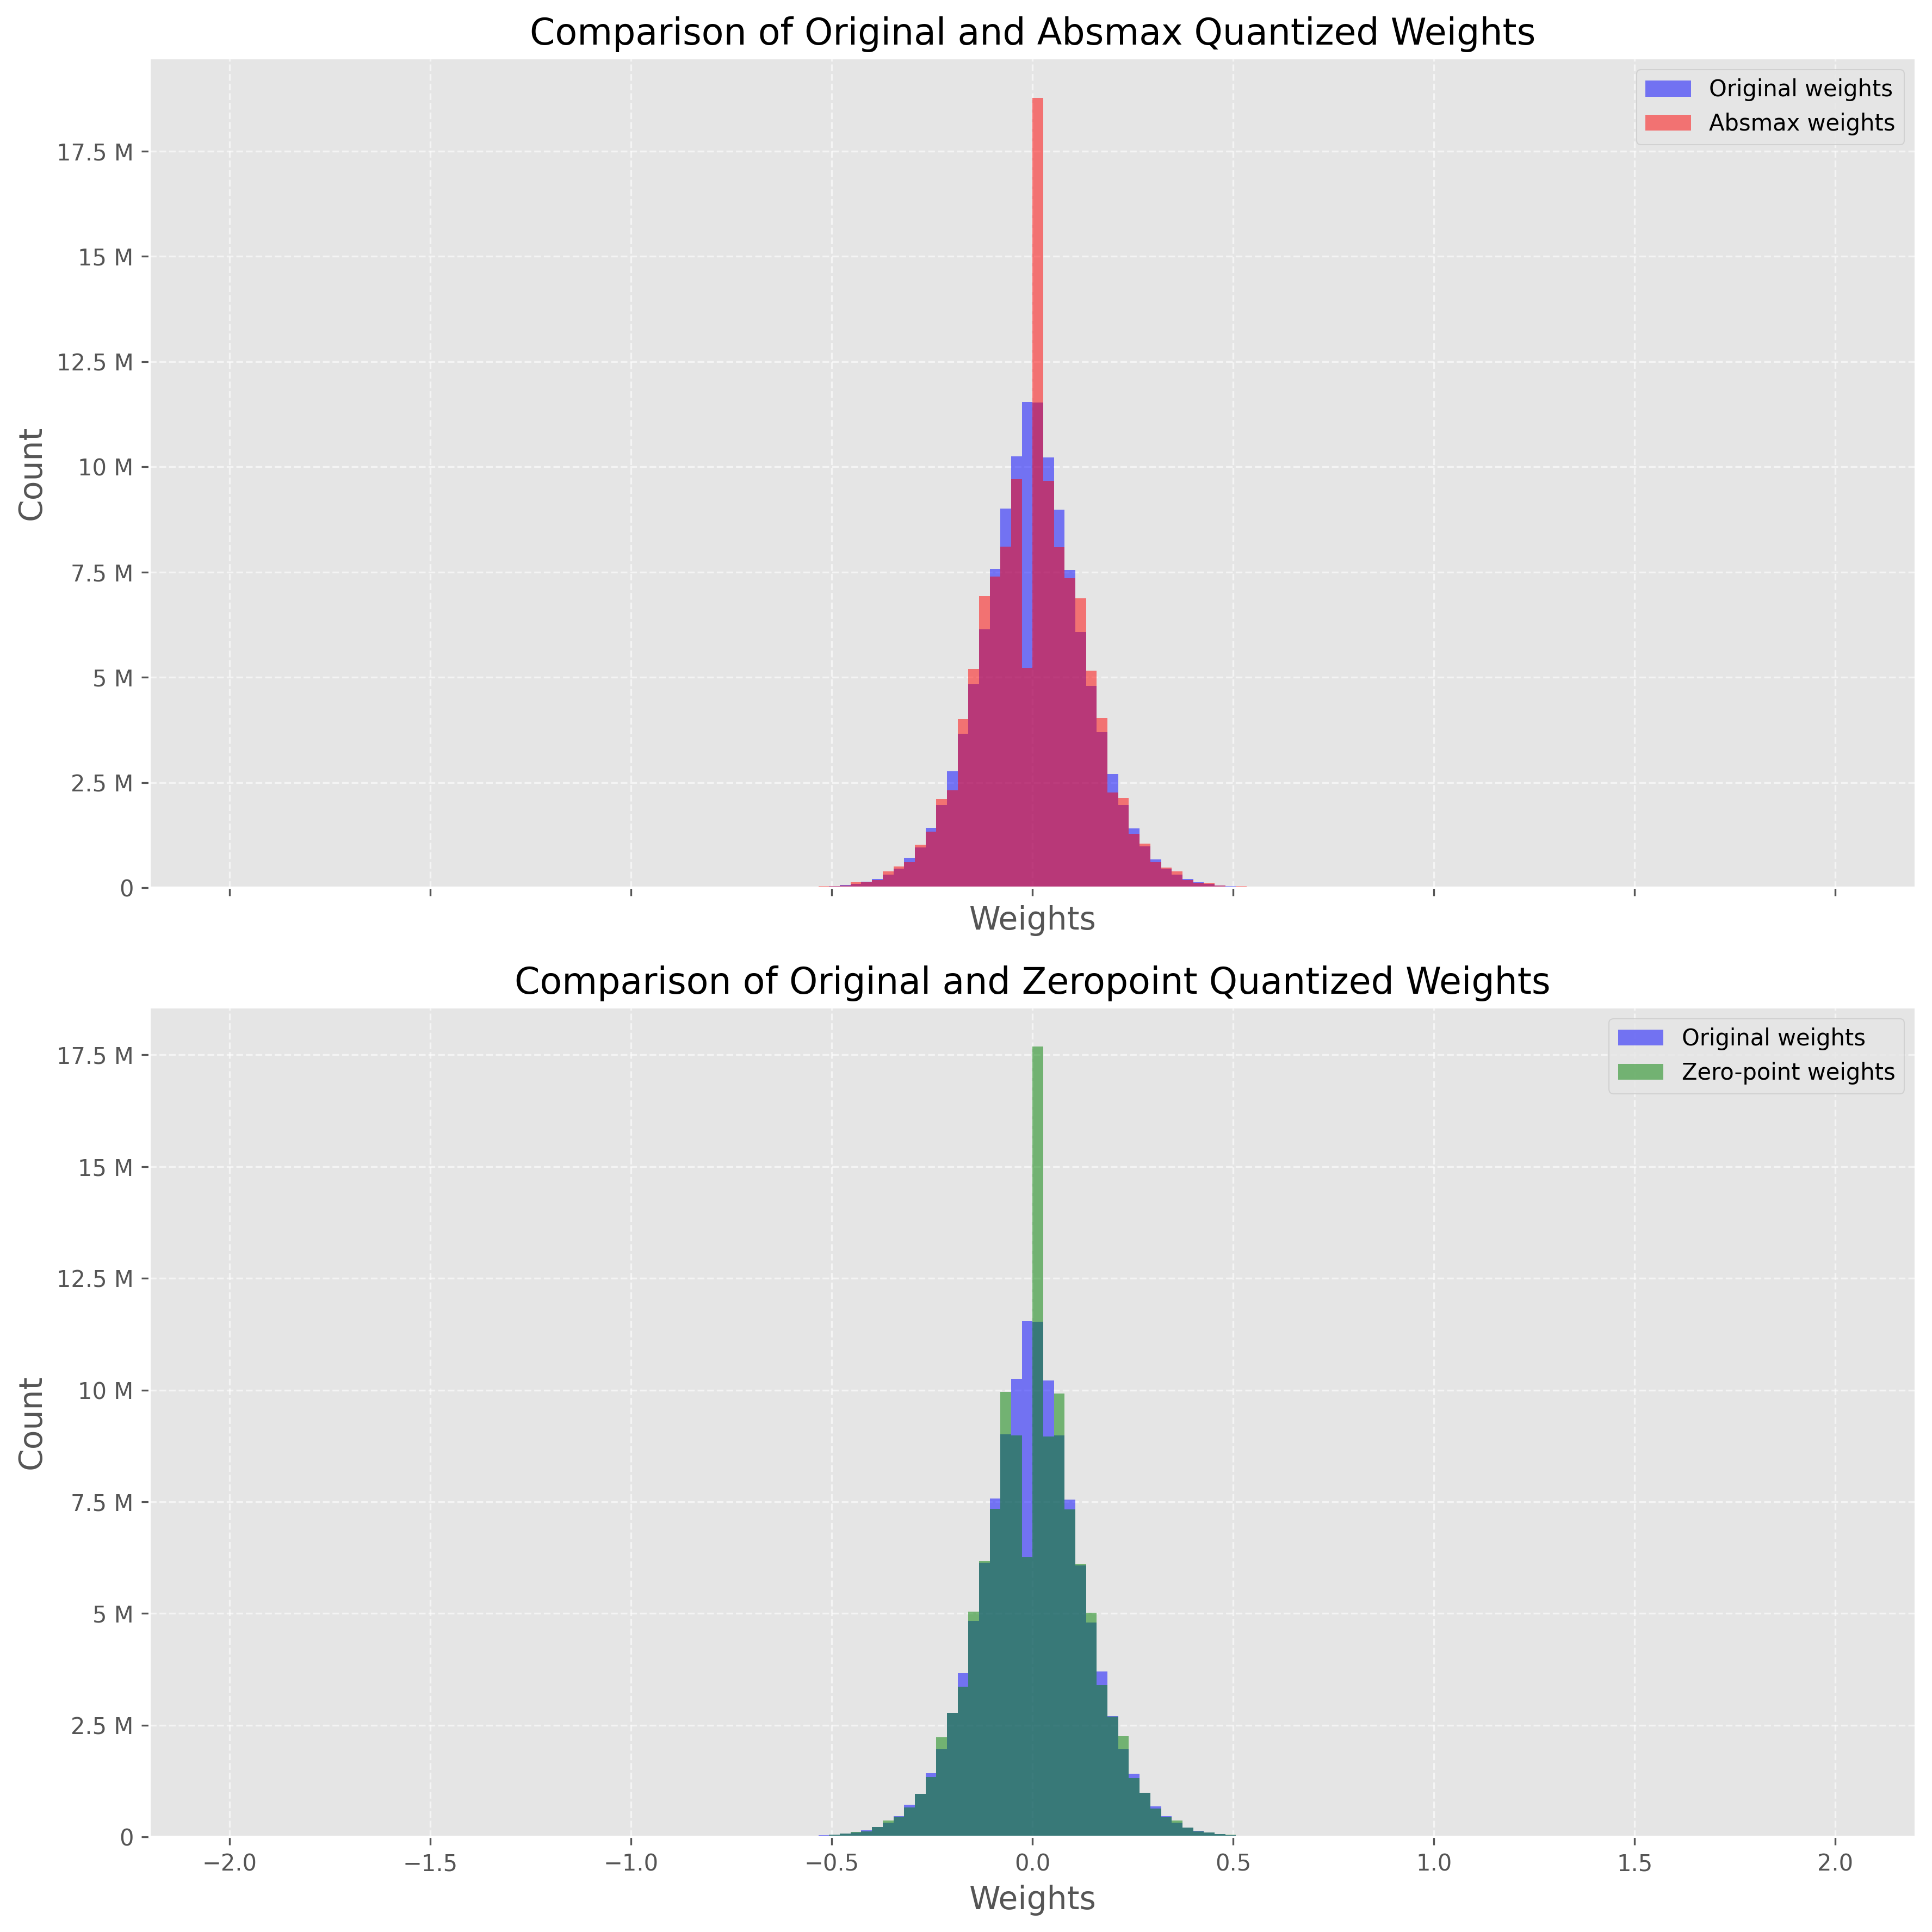

In [60]:
# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(12,12), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

The following figure shows this comparison, where the blue histogram represents the original (FP32) weights, and the red one represents the dequantized (from INT8) weights. 

Note that we only display this plot between -2 and 2 because of outliers with very high absolute values (more on that later).

Both plots are quite similar, with a surprising spike around 0. This spike shows that our quantization is quite lossy since reversing the process doesn’t output the original values. 

This is particularly true for the absmax model, which displays both a lower valley and a higher spike around 0.

In [8]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream, and it is a dream I believe I would get to live in my future. I love my mother, and there was that one time I had been told that my family wasn't even that strong. And then I got the
--------------------------------------------------
Absmax model:
I have a dream to find out the origin of her hair. She loves it. But there's no way you could be honest about how her hair is made. She must be crazy.

We found a photo of the hairstyle posted on
--------------------------------------------------
Zeropoint model:
I have a dream of creating two full-time jobs in America—one for people with mental health issues, and one for people who do not suffer from mental illness—or at least have an employment and family history of substance abuse, to work part


In [9]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 15.53
Absmax perplexity:   17.92
Zeropoint perplexity: 17.97


## 8-bit Quantization with LLM.int8()

[LLM.int8(): 8-bit Matrix Multiplication for Transformers at Scale](https://arxiv.org/abs/2208.07339) is a solution to the outlier problem. It relies on a vector-wise (absmax) quantization scheme and introduces mixed-precision quantization. This means that outlier features are processed in a FP16 format to retain their precision, while the other values are processed in an INT8 format. As outliers represent about 0.1% of values, this effectively reduces the memory footprint of the LLM by almost 2x.
 
<img src = "figures/quantize-int8.webp" width=500>

LLM.int8() works by conducting matrix multiplication computation in three key steps:
Extract columns from the input hidden states X containing outlier features using a custom threshold.
1. Perform the matrix multiplication of the outliers using FP16 and the non-outliers using INT8 with vector-wise quantization (row-wise for the hidden state X and column-wise for the weight matrix W).
2. Dequantize the non-outlier results (INT8 to FP16) and add them to the outlier results to get the full result in FP16.

<img src = "figures/llm-int8.webp" width=500>

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = "gpt2"
model_int8 = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    load_in_8bit=True, #Caution : requires a GPU
    )

print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

Model size: 176,527,896 bytes


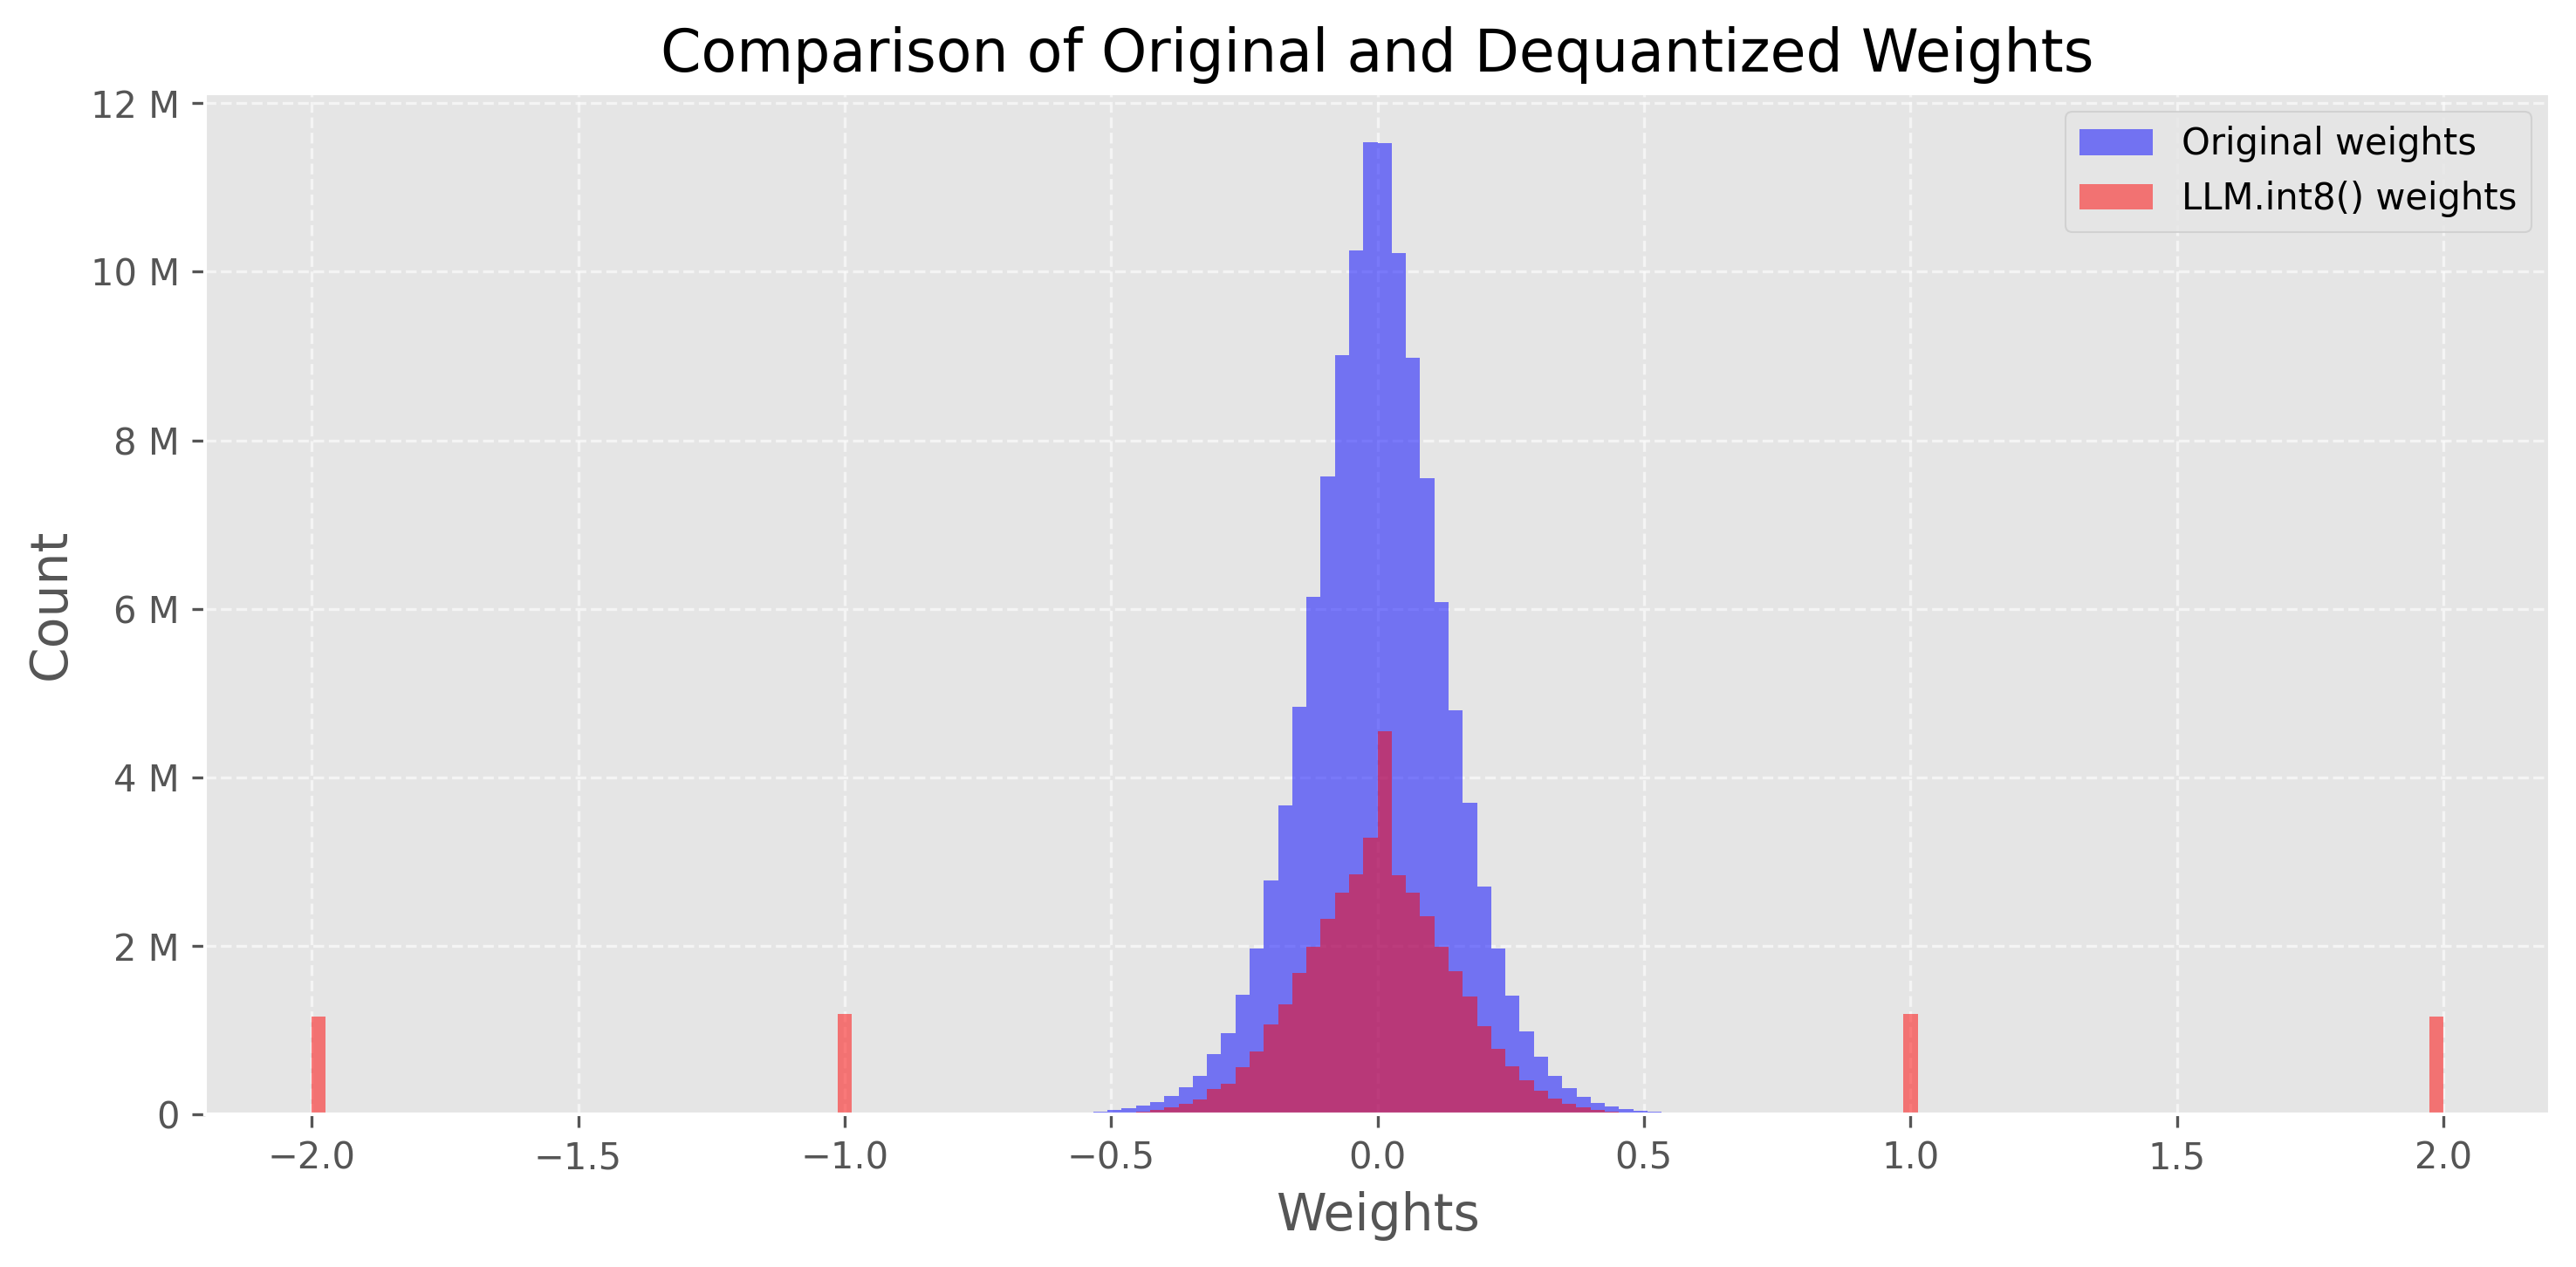

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In this case, we see spikes around -2, -1, 0, 1, 2, etc. These values correspond to the parameters stored in the INT8 format (non-outliers). 

In [13]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream, and it is a dream I believe I would get to live in my future. I love my mother, and there was that one time I had been told that my family wasn't even that strong. And then I got the
--------------------------------------------------
LLM.int8() model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing


In [14]:
ppl = calculate_perplexity(model, original_text)
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   15.53
Perplexity (LLM.int8()): 7.94


# Reference
- [Quantization Huggingface](https://huggingface.co/docs/accelerate/usage_guides/quantization)
- [Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
- [A Gentle Introduction to 8-bit Matrix Multiplication for transformers at scale](https://huggingface.co/blog/hf-bitsandbytes-integration)
- [ML Blog Introduction to Weight Quantization](https://mlabonne.github.io/blog/intro_weight_quantization/)
- [Introduction to Weight Quantization](https://towardsdatascience.com/introduction-to-weight-quantization-2494701b9c0c)
- [4-bit Quantization with GPTQ](https://towardsdatascience.com/4-bit-quantization-with-gptq-36b0f4f02c34)
- [Large Transformer Model Inference Optimization](https://lilianweng.github.io/posts/2023-01-10-inference-optimization/)